In [2]:
import torch
import torchvision
import sys
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True


In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
import numpy as np


np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [17]:
import cv2
# image = Image.open('/home/cs24m118/datasets/rgb_anon_trainvaltest/rgb_anon/fog/train/GOPR0476/GOPR0476_frame_000442_rgb_anon.png')
image = Image.open('/home/cs24m118/datasets/rgb_anon_trainvaltest/rgb_anon/fog/train/GP020478/GP020478_frame_000314_rgb_anon.png')
image = np.array(image.convert("RGB"))
# downscale to reduce VRAM (adjust as needed)
image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)


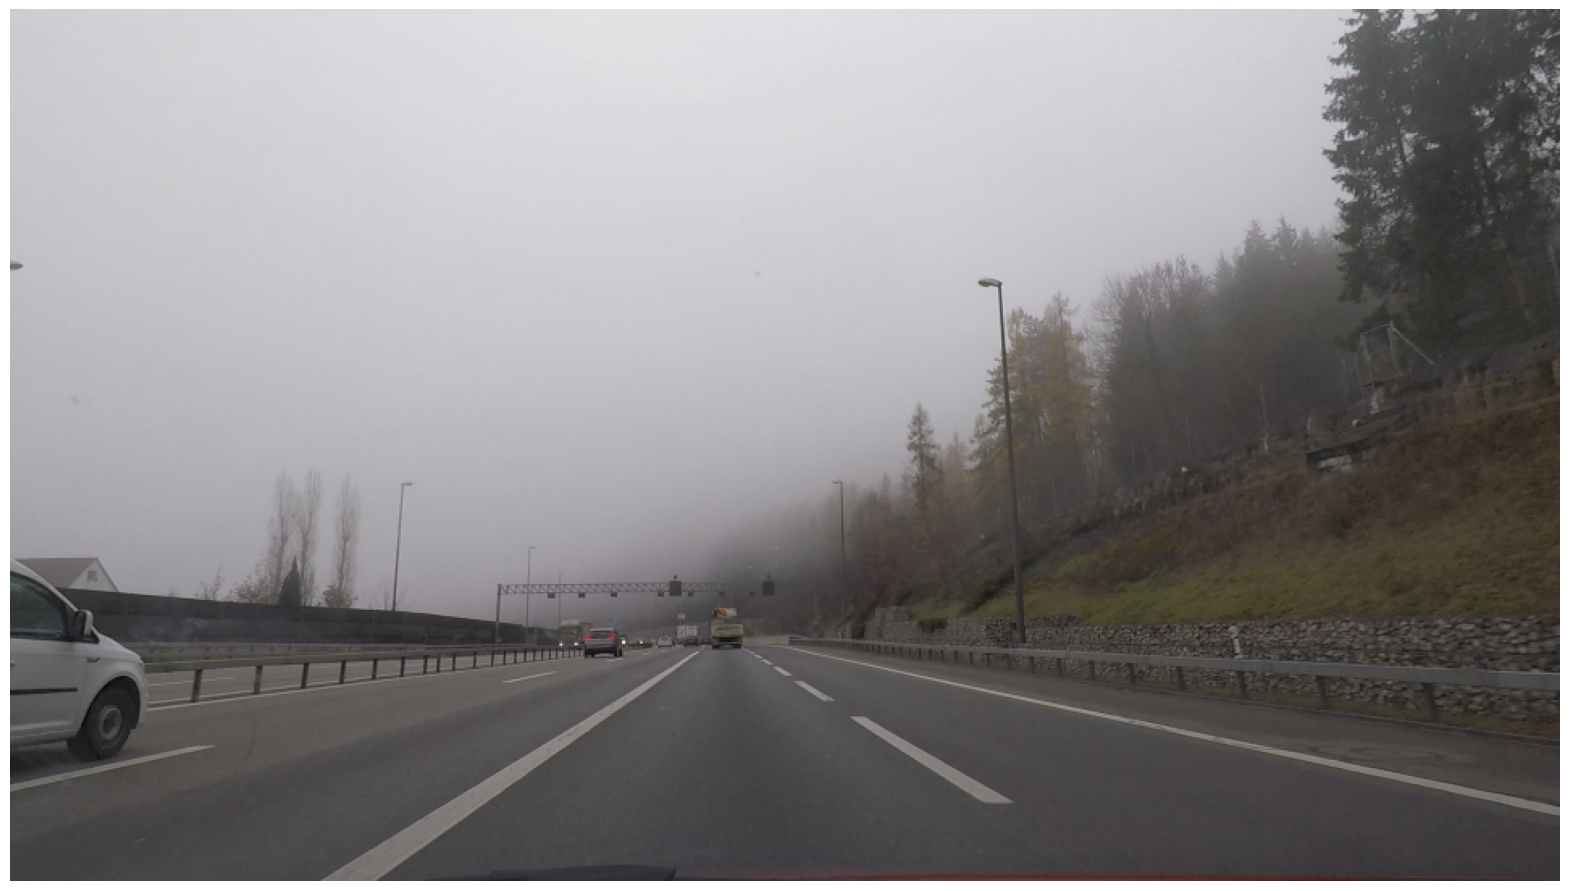

In [18]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [10]:
import sys
sys.path.insert(0, "/home/cs24m118/phase2/mysam2")

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "/home/cs24m118/phase2/mysam2/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "../../mysam2/sam2/configs/sam2.1/sam2.1_hiera_b+.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2, points_per_side=16, points_per_batch=16)


In [19]:
masks = mask_generator.generate(image)

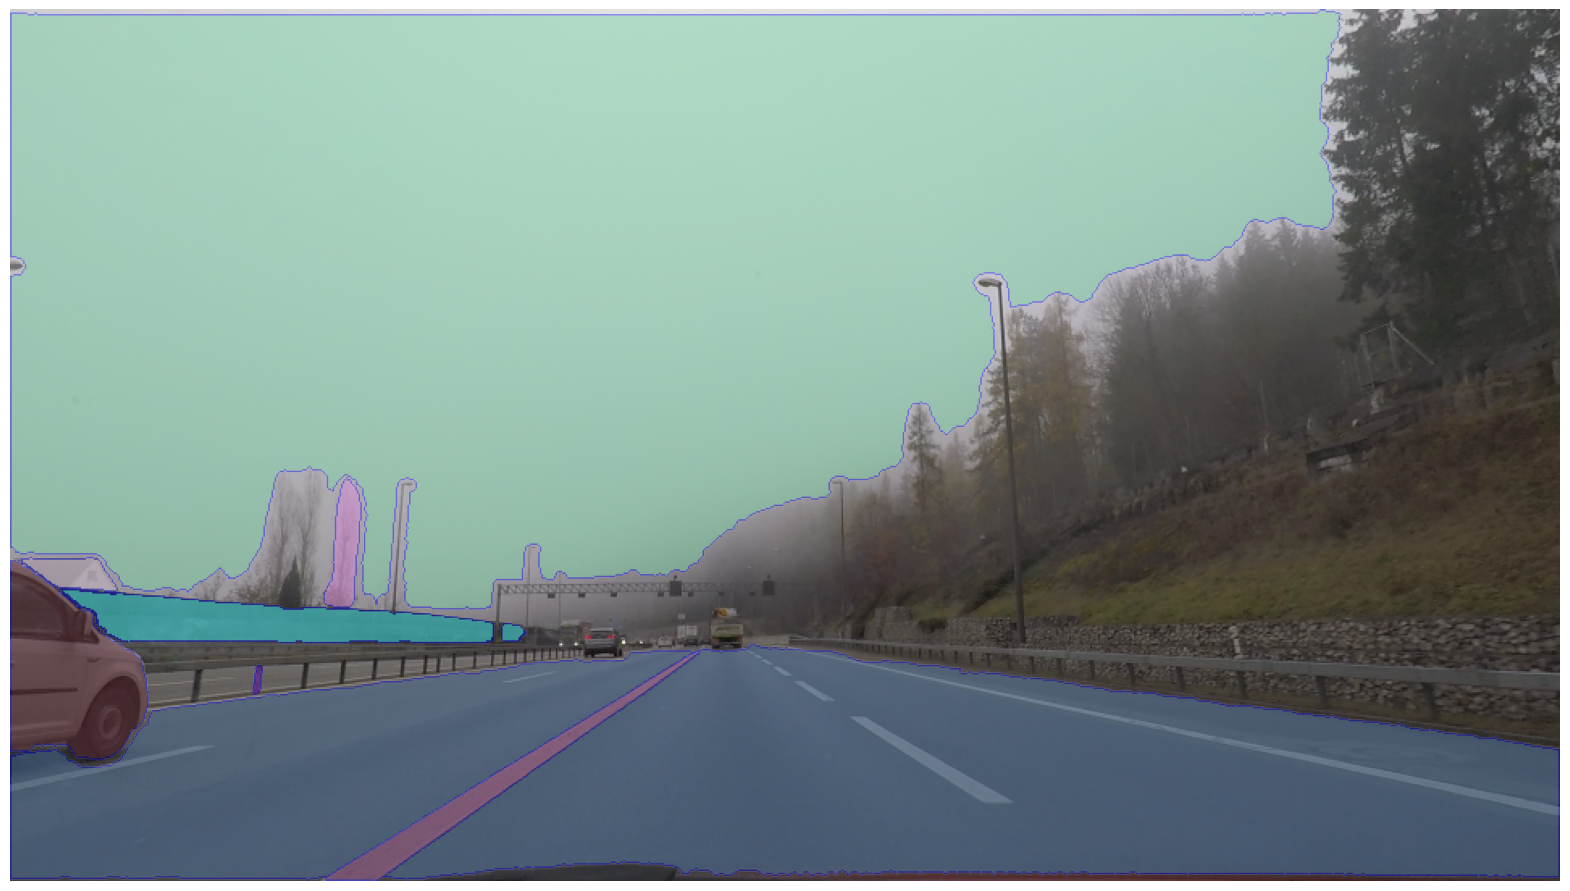

In [20]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [14]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [21]:
masks2 = mask_generator_2.generate(image)

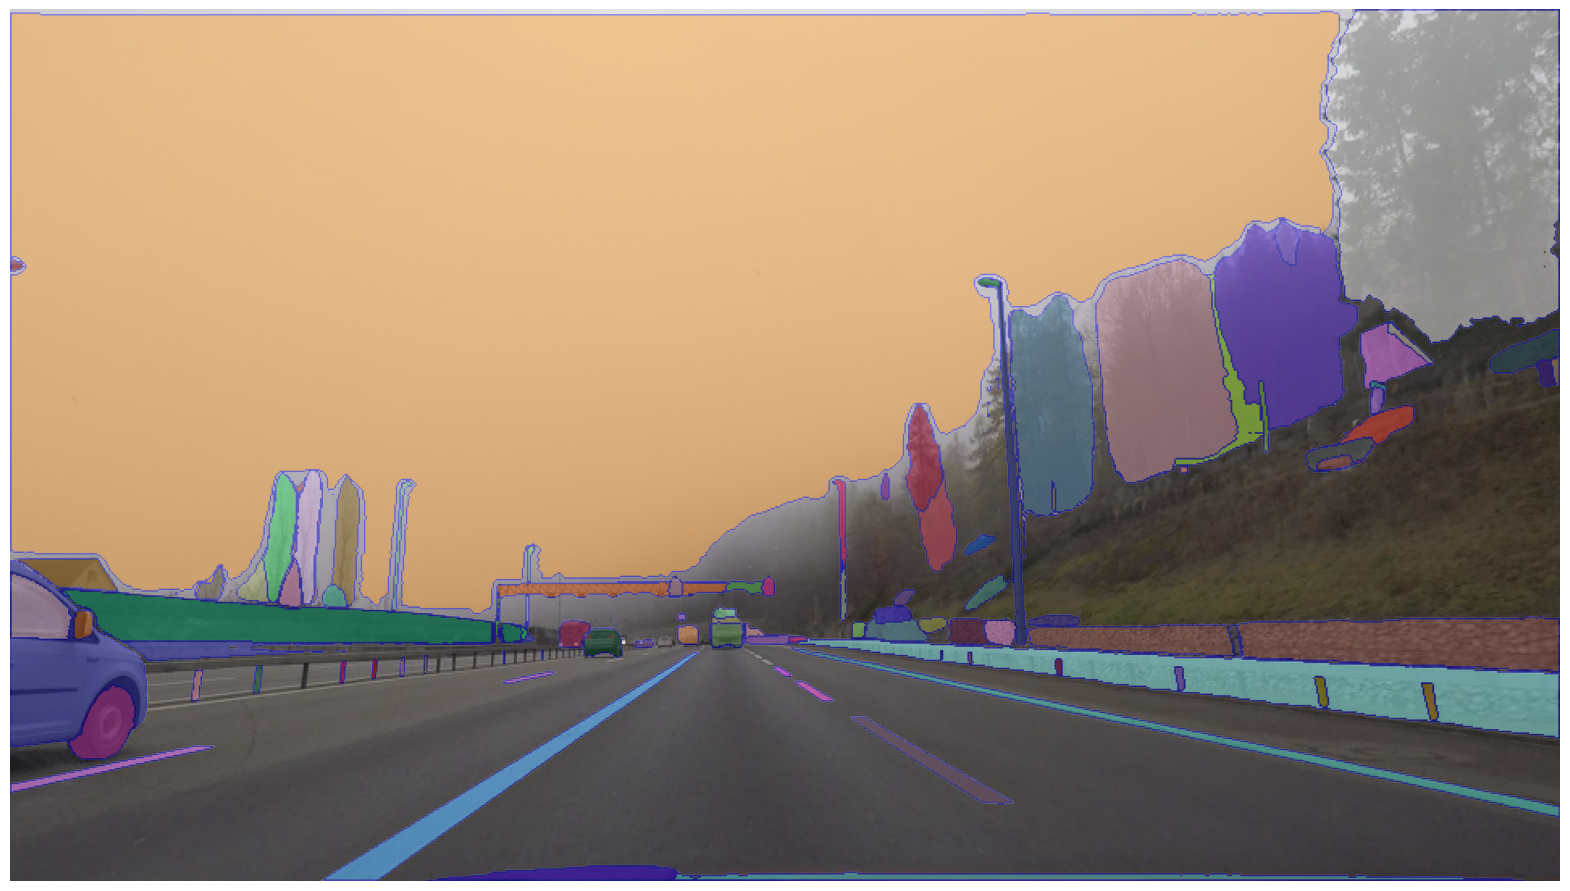

In [22]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [24]:
import cv2
image = Image.open('/home/cs24m118/datasets/rgb_anon_trainvaltest/rgb_anon/night/train/GOPR0376/GOPR0376_frame_000038_rgb_anon.png')
image = np.array(image.convert("RGB"))
# downscale to reduce VRAM (adjust as needed)
image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

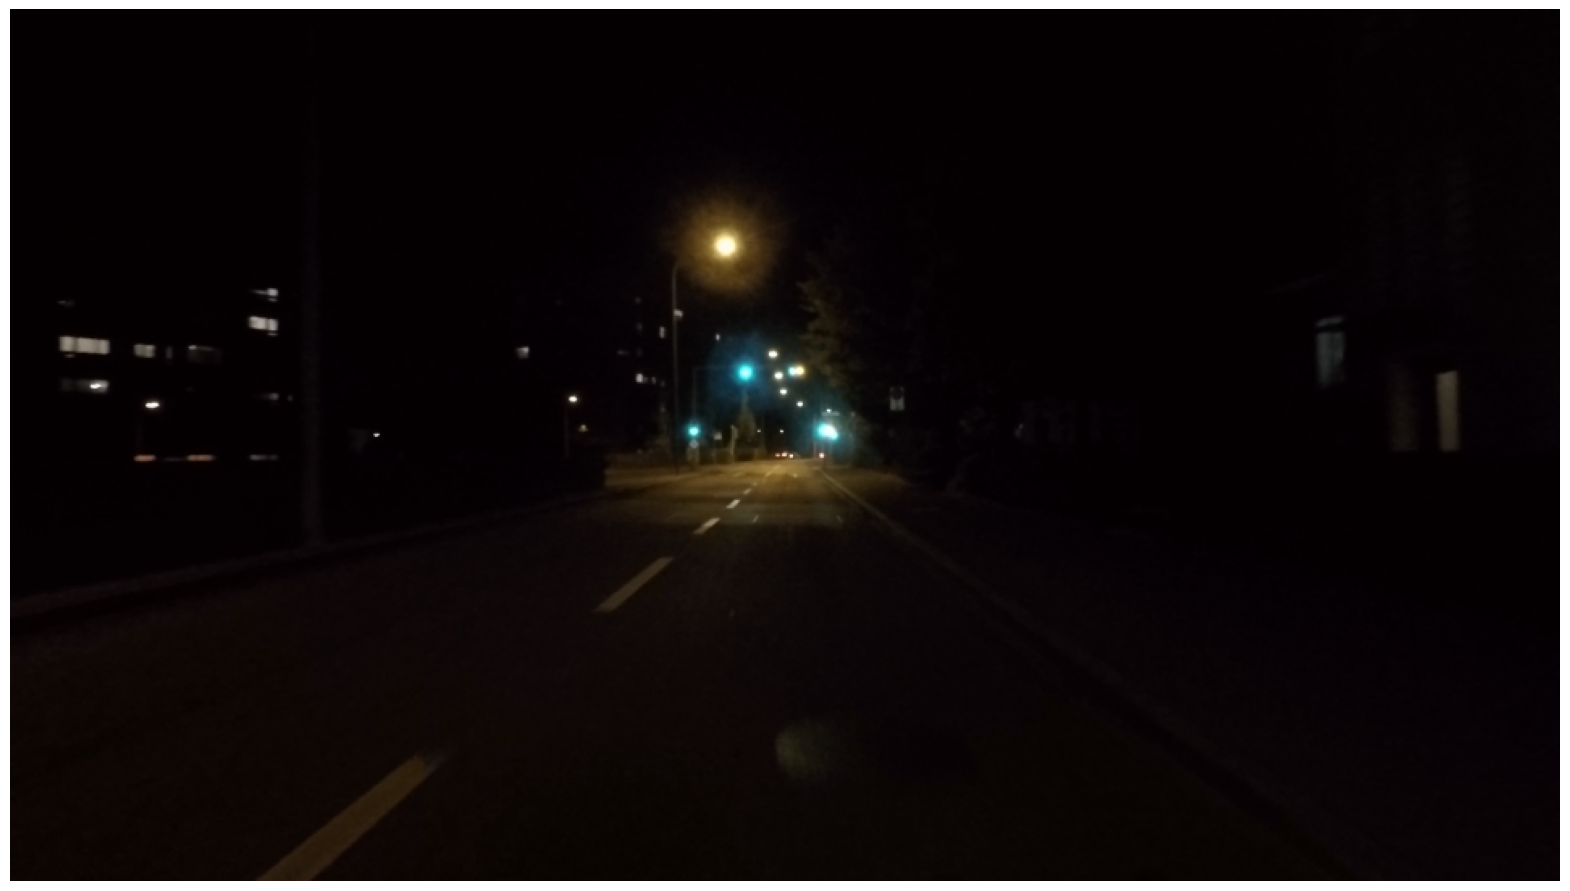

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show() 

In [27]:
masks = mask_generator.generate(image)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.show_anns()
plt.axis('off')
plt.show() 